In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
PATH = '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA'
MGF = '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/SA001-R3-A-2ulf.raw.mgf'

In [6]:
from TB.c import *

In [7]:
glob(f'{PATH}/*')

['/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/allPeptides.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/evidence.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/fragment.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/matchedFeatures.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/maxquant_quality_control.csv',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/meta.json',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/modificationSpecificPeptides.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/ms3Scans.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/msms.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/msmsScans.txt',
 '/data/lrg_omics_test_data/proteomics/tmt11/raw/SA001-R3-A-2ulf/MQ/SA/mzRange.txt',
 '/data/lrg_omi

In [273]:
with pd.option_context('display.max_rows', 100):
    display( pd.read_csv(f'{PATH}/msmsScans.txt', sep='\t', index_col='Scan index').max() )

Raw file                                      SA001-R3-A-2ulf
Scan number                                             29827
Retention time                                         89.075
Ion injection time                                        NaN
Total ion current                                  1263900000
Collision energy                                           38
Summations                                                  0
Base peak intensity                                 2.843e+08
Elapsed time                                            0.359
Identified                                                  -
Matched                                                   NaN
MS/MS IDs                                                7287
Sequence                                              YYVYNDR
Length                                                     42
Filtered peaks                                            456
m/z                                                   1228.78
Mass    

In [344]:
pd.read_csv(f'{PATH}/proteinGroups.txt', sep='\t')[['id', 'Best MS/MS']]

,id,Best MS/MS
0,0,1444;1658;2820;3459
1,1,6272
2,2,453;859;2588;3663;4334
3,3,706;1393;2791
4,4,2528;2629;4655;4852;4897;5451
...,...,...
1343,1343,5317
1344,1344,3522
1345,1345,4667
1346,1346,6612


In [363]:
df = pd.read_csv(f'{PATH}/msmsScans.txt', sep='\t')[['Scan number', 'Scan index', 'MS scan index', 'MS scan number']]
df

,Scan number,Scan index,MS scan index,MS scan number
0,2594,0,2592,2593
1,2601,1,2598,2600
2,2617,2,2613,2616
3,2618,3,2613,2616
4,2621,4,2615,2620
...,...,...,...,...
22065,29687,22065,7620,29685
22066,29690,22066,7622,29689
22067,29700,22067,7631,29699
22068,29789,22068,7719,29788


In [367]:
(df == 1658).sum()

Scan number       0
Scan index        1
MS scan index     0
MS scan number    0
dtype: int64

In [47]:
def spectrum_to_df(spectrum):
    rt_entry_to_float_minutes = lambda x: float(x)/60
    df = pd.DataFrame()
    df['mz_array'] = spectrum['m/z array']
    df['intensity'] = spectrum['intensity array']
    df['spectrum'] = spectrum['params']['title']
    df['raw_file'] = spectrum['params']['rawfile']
    df['retention_time[min]'] = rt_entry_to_float_minutes(spectrum['params']['rtinseconds'])
    return df

In [586]:
from pyteomics import mgf

class MaxQuantResult():
    def __init__(self, path=None, mgf_file=None):
        if path is not None:
            self.read(path)
        else:
            self._evidence = pd.DataFrame()
            self._msms =  pd.DataFrame()
            self._proteins =  pd.DataFrame()
            self._peptides = pd.DataFrame()
        if mgf_file is not None:
            self.add_spectra(mgf_file)
        else:
            self._spectra = None
            
    def read(self, path):
        self._evidence = pd.read_csv(f'{path}/evidence.txt', sep='\t')
        self._msms = pd.read_csv(f'{path}/msmsScans.txt', sep='\t', index_col='Scan index')
        self._proteins = pd.read_csv(f'{path}/proteinGroups.txt', sep='\t', index_col='id')
        self._peptides = pd.read_csv(f'{path}/peptides.txt', sep='\t')      
        
    def add_spectra(self, mgf_file):
        self._spectra = mgf.read(mgf_file)
    
    def get_spectrum(self, index):
        if self._spectra is None:
            return None
        df = spectrum_to_df( self._spectra.get_by_index(index) )
        df['Scan index'] = index
        return df
    
    def get_proteins(self, ids=None, regex=None, seq=None, cols=None):
        if cols is None:
            cols = []
        df = self._proteins
        if ids is not None:
            df = df.loc[ids]
        if regex is not None:
            df = df[df['Protein IDs'].str.contains(regex)]
        if seq is not None:
            df = df[df.Sequence.str.contains(seq)]
        return df
    
    def get_msms_scan_index(self, protein_id=None, column='Best MS/MS'):
        if protein_id is not None:
            df = self._proteins
            scan_index = [ int(i) for i in df.loc[protein_id][column].split(';')]
            return scan_index       
    
    def get_spectra(self, protein_id=None):
        if self._spectra is None:
            return None
        if protein_id is not None:
            scan_index = self.get_msms_scan_index(protein_id=protein_id)
            spectra = []
            for ndx in scan_index:
                spectrum = self.get_spectrum(ndx)
                spectra.append(spectrum)
            return pd.concat(spectra)
    

In [587]:
results = MaxQuantResult(PATH, MGF)

In [588]:
results.get_proteins(1)

Protein IDs                      100|Superoxide_dismutase_[Mn/Fe]_2|100.0%
Majority protein IDs             100|Superoxide_dismutase_[Mn/Fe]_2|100.0%
Peptide counts (all)                                                     1
Peptide counts (razor+unique)                                            1
Peptide counts (unique)                                                  1
                                                   ...                    
MS/MS IDs                                                             6272
Best MS/MS                                                            6272
Oxidation (M) site IDs                                                 NaN
Oxidation (M) site positions                                           NaN
Taxonomy IDs                                                            -1
Name: 1, Length: 70, dtype: object

In [589]:
results.get_msms_scan_index(protein_id=0)

[1444, 1658, 2820, 3459]

In [689]:
results.get_spectra(protein_id=0)

,mz_array,intensity,spectrum,raw_file,retention_time[min],Scan index
0,117.42187,892.7188,Spectrum_4201,/var/www/html/omics/projects/LSARP/proteomics/...,21.582061,1444
1,118.82234,906.3354,Spectrum_4201,/var/www/html/omics/projects/LSARP/proteomics/...,21.582061,1444
2,126.12745,81631.8203,Spectrum_4201,/var/www/html/omics/projects/LSARP/proteomics/...,21.582061,1444
3,127.12449,17556.7852,Spectrum_4201,/var/www/html/omics/projects/LSARP/proteomics/...,21.582061,1444
4,127.13079,38162.6055,Spectrum_4201,/var/www/html/omics/projects/LSARP/proteomics/...,21.582061,1444
...,...,...,...,...,...,...
290,719.48505,8554.0518,Spectrum_6467,/var/www/html/omics/projects/LSARP/proteomics/...,26.506011,3459
291,720.41821,2754.3704,Spectrum_6467,/var/www/html/omics/projects/LSARP/proteomics/...,26.506011,3459
292,720.49213,4988.7520,Spectrum_6467,/var/www/html/omics/projects/LSARP/proteomics/...,26.506011,3459
293,743.38977,3019.7681,Spectrum_6467,/var/www/html/omics/projects/LSARP/proteomics/...,26.506011,3459


In [690]:
def plot_spectrum(df, annot_threshold=1e4, threshold=0, show_fig=True, **kwargs):
    """Plots spectral data. df is a pandas.DataFrame() with the columns
       mz_array
       intensity
       spectrum
       raw_file
       retention_time[min]
       Scan index
    """
    df = df[df.intensity > threshold]
    df['_index_'] = range(len(df))
    
    df1 = df.copy()
    df1['Text'] = df1.mz_array.astype(str)
    df1.loc[df1.intensity < annot_threshold, 'Text'] = None
    df1.Text.notnull().sum()

    df2 = df.copy()
    df2['intensity'] = 0
    
    df3 = pd.concat([df1, df2]).sort_values(['_index_', 'intensity'])
    
    grps = df3.groupby('Scan index')
    
    figs = []
    for label, grp in grps:
        fig = px.line(grp, x='mz_array', y='intensity', color='_index_', text='Text',
                      hover_data={'Text': False, '_index_': False}, **kwargs)

        fig.update_layout(showlegend=False, title=f'Scan index: {label}')
        fig.update_traces(line=dict(width=1, color='grey'))
        fig.update_traces(textposition='top center')
        fig.update_layout(hovermode="x unified")

        if show_fig: fig.show()
        figs.append(fig)
        
    return figs

In [691]:
df = viewer.get_spectra(0)

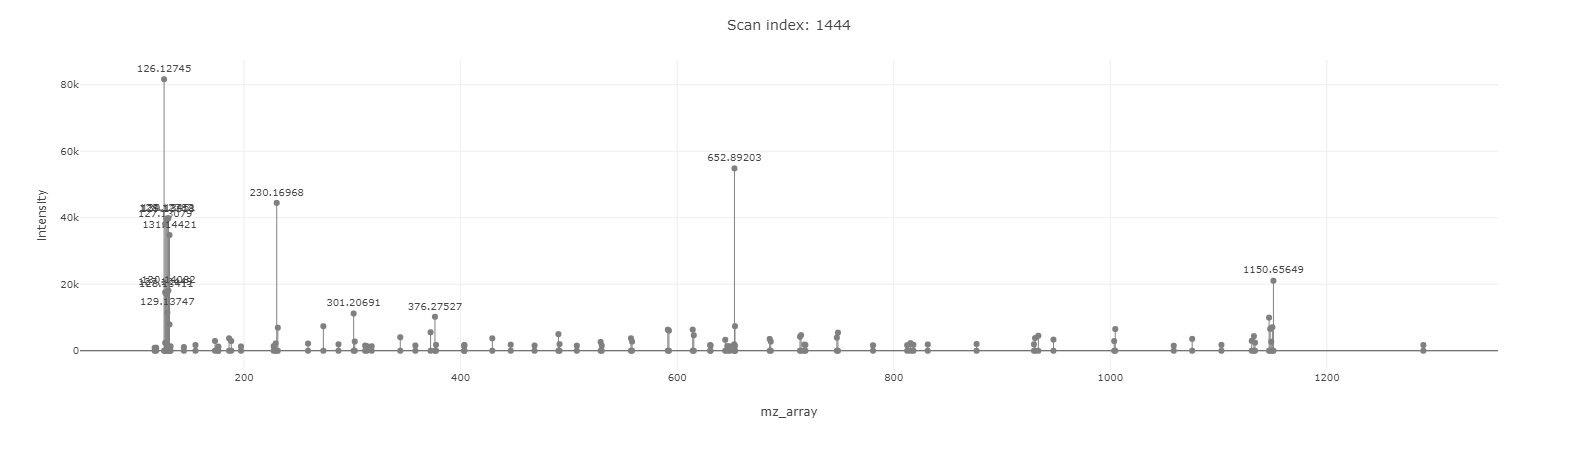

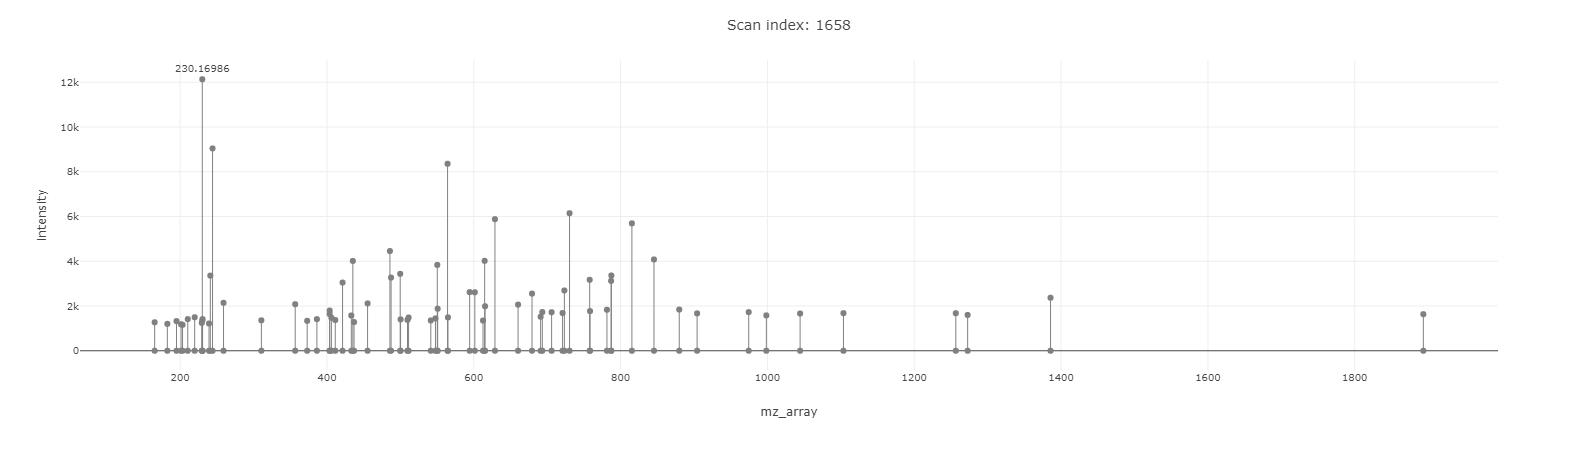

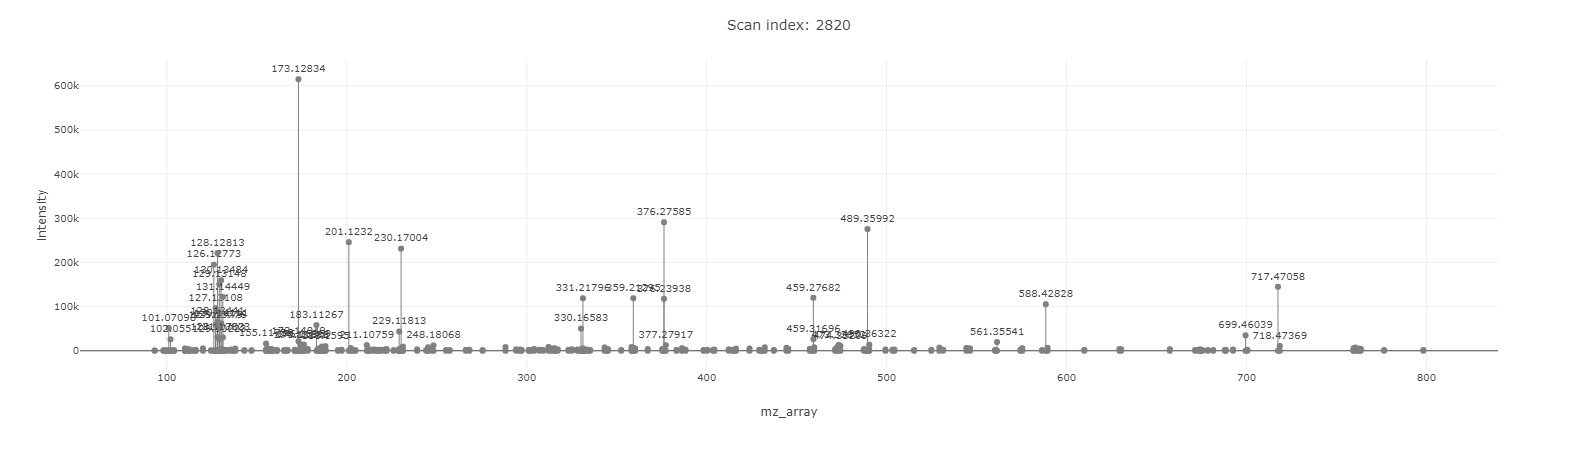

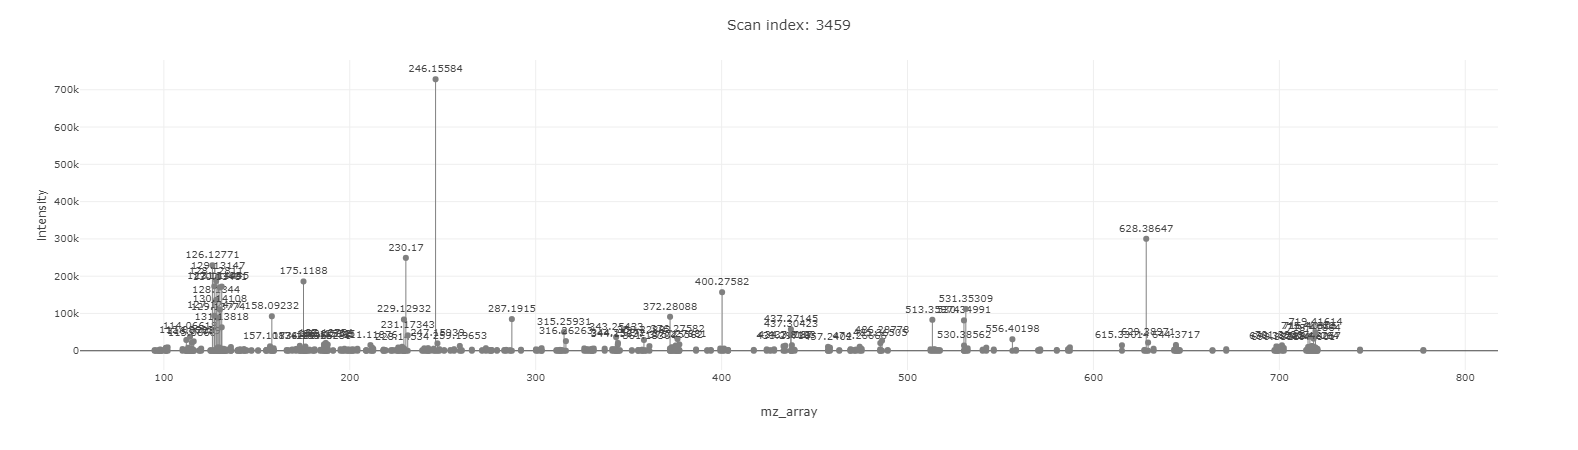

In [692]:
_ = plot_spectrum(df)

In [668]:
import plotly.express as px

from lrg_omics.plotly import set_template
set_template()

In [669]:
class MaxQuantViewer(MaxQuantResult):
    def plot_spectra(self, protein_id=None):
        spectra = self.get_spectra(protein_id)
        fig = plot_spectrum(spectra)
        return fig

viewer = MaxQuantViewer(PATH, MGF)
df = viewer.get_spectra(3)

In [482]:
viewer.plot_spectra(protein_id=0)

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
